Train Test Split

In [38]:
import librosa
import soundfile as sf
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import shutil
from scipy.stats import multivariate_normal

def extract_mfcc(file_path, n_mfcc=13, hop_length=512, n_fft=2048):
    # Load audio file using soundfile
    audio, sr = sf.read(file_path)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

    return mfccs

def process_timit_data(data_path, output_path):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Process each TIMIT file
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".WAV"):
                file_path = os.path.join(root, file)
                
                # Extract subfolder name from the TIMIT path
                subfolder_name = os.path.relpath(root, data_path)

                # Create subfolder in the output directory
                output_subfolder = os.path.join(output_path, subfolder_name)
                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)

                # Extract MFCC features
                mfccs = extract_mfcc(file_path)

                # Save MFCC matrix in the subfolder
                output_file = os.path.join(output_subfolder, os.path.splitext(file)[0] + "_mfcc.npy")
                np.save(output_file, mfccs.T)

                print(f"Processed {file} and saved MFCC matrix to {output_file}")

# if __name__ == "__main__":
#     # Set the path to the TIMIT dataset and output directory
timit_data_path = "./Data/"
output_directory = "./Output"

#     process_timit_data(timit_data_path, output_directory)

Divide train test

In [37]:
train_dir = "./train/"
test_dir = "./test/"

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

folders = os.listdir(output_directory)[2:]

# For each folder in file_list, keep 80% of files in train directory and 20% in test directory
train_files = []
test_files = []

for folder in folders:
    files = glob(os.path.join(output_directory, folder, "*.npy"))
    np.random.shuffle(files)
    split_index = int(0.8 * len(files))
    train_files.extend(files[:split_index])
    test_files.extend(files[split_index:])
    
# Copy files to train directory
for file in train_files:
    subfolder_name = os.path.relpath(os.path.dirname(file), output_directory)
    output_subfolder = os.path.join(train_dir, subfolder_name)
    os.makedirs(output_subfolder, exist_ok=True)
    shutil.copy(file, output_subfolder)

# Copy files to test directory
for file in test_files:
    subfolder_name = os.path.relpath(os.path.dirname(file), output_directory)
    output_subfolder = os.path.join(test_dir, subfolder_name)
    os.makedirs(output_subfolder, exist_ok=True)
    shutil.copy(file, output_subfolder)

# GMM

In [34]:
speakers = os.listdir(output_directory)[2:]
os.makedirs(os.path.join(train_dir, "CONCAT"), exist_ok=True)

for speaker in speakers:
    files = glob(os.path.join(train_dir, speaker, "*.npy"))

    # create 8 x N x 13 array for each speaker
    for i, file in enumerate(files):
        mfccs = np.load(file)
        if i == 0:
            speaker_mfccs = mfccs
        else:
            speaker_mfccs = np.concatenate((speaker_mfccs, mfccs), axis=0)

    np.save(os.path.join(train_dir, "CONCAT", speaker + ".npy"), speaker_mfccs)

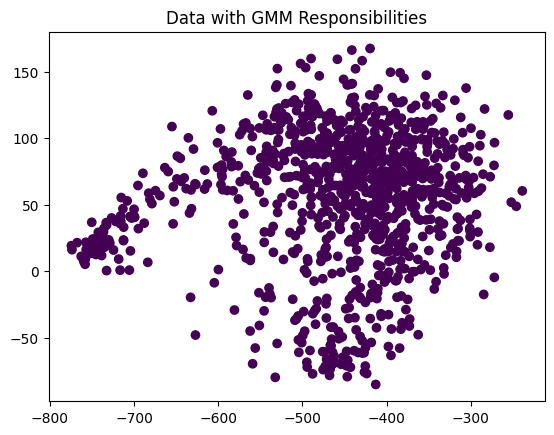

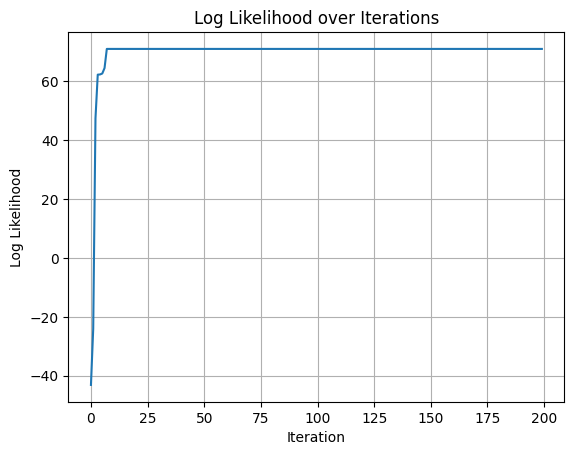

In [42]:
def gauss_dist_multivariate(X, mean, cov):
    mvn = multivariate_normal(mean=mean, cov=cov)
    return mvn.pdf(X)


def gmm(X, num_mixtures, max_iter=200):
    num_data, num_features = X.shape

    # Initialize parameters
    np.random.seed(42)
    temp = np.random.permutation(num_data)

    piecap = np.ones((max_iter + 1, num_mixtures)) / num_mixtures
    meucap = np.zeros((max_iter + 1, num_mixtures, num_features))
    sigmacap = np.zeros((max_iter + 1, num_mixtures, num_features, num_features))
    log_likelihood = np.zeros(max_iter + 1)
    responsibilities = np.zeros((max_iter + 1, num_data, num_mixtures))

    for j in range(num_mixtures):
        meucap[0, j, :] = X[temp[j]]
        sigmacap[0, j, :, :] = np.cov(X.T)

    for i in range(max_iter):
        # Expectation Step
        for j in range(num_mixtures):
            responsibilities[i, :, j] = piecap[i, j] * gauss_dist_multivariate(
                X, meucap[i, j, :], sigmacap[i, j, :, :]
            )

        responsibilities[i, :, :] /= np.sum(responsibilities[i, :, :], axis=0)[
            np.newaxis, :
        ]

        # Maximization Step
        for j in range(num_mixtures):
            meucap[i + 1, j, :] = np.sum(
                responsibilities[i, :, j][:, np.newaxis] * X, axis=0
            ) / np.sum(responsibilities[i, :, j])
            diag_reg = 1e-6  # small regularization term
            sigmacap[i + 1, j, :, :] = (
                np.dot(
                    (
                        responsibilities[i, :, j][:, np.newaxis]
                        * (X - meucap[i + 1, j, :])
                    ).T,
                    (X - meucap[i + 1, j, :]),
                )
                + diag_reg * np.eye(num_features)
            ) / np.sum(responsibilities[i, :, j])

            piecap[i + 1, j] = np.sum(responsibilities[i, :, j]) / num_data

        # Compute log likelihood
        log_likelihood[i] = np.sum(
            np.log(
                np.sum(
                    piecap[i + 1, j]
                    * gauss_dist_multivariate(
                        X, meucap[i + 1, j, :], sigmacap[i + 1, j, :, :]
                    ),
                    axis=0,
                )
            )
        )

    return meucap, sigmacap, piecap, log_likelihood, responsibilities


os.makedirs("gmm", exist_ok=True)

for speaker in speakers:
    # Perform GMM on 2D data
    data = np.load(os.path.join(train_dir, "CONCAT", speaker + ".npy"))

    # Apply GMM
    num_mixtures = 13
    meucap, sigmacap, piecap, log_likelihood, responsibilities = gmm(data, num_mixtures)

    gmm_model = {
        "meucap": meucap,
        "sigmacap": sigmacap,
        "piecap": piecap,
        "responsibilities": responsibilities,
    }
    np.save(os.path.join("gmm", speaker + ".npy"), gmm_model)
    
    # Plot log likelihood of one speaker
    if speaker == speakers[0]:
        plt.figure()
        plt.scatter(
            data[:, 0], data[:, 1], c=np.argmax(responsibilities[-1], axis=1), cmap="viridis"
        )
        plt.title("Data with GMM Responsibilities")
        plt.show()

        # Plot log likelihood over iterations
        plt.figure()
        plt.plot(log_likelihood[:200])
        plt.xlabel("Iteration")
        plt.ylabel("Log Likelihood")
        plt.title("Log Likelihood over Iterations")
        plt.grid()
        plt.show()

In [51]:
#load GMM model for one speaker
gmm_one=np.load(os.path.join("gmm", speakers[0] + ".npy"),allow_pickle=True).item()
gmm_two=np.load(os.path.join("gmm", speakers[1] + ".npy"),allow_pickle=True).item()

meucap_one=gmm_one['meucap'][-1,:,0]
sigmacap_one=gmm_one['sigmacap'][-1,...,0]
meucap_two=gmm_two['meucap'][-1,:,0]
sigmacap_two=gmm_two['sigmacap'][-1,...,0]

#visualize GMM for one speaker

guass_one=multivariate_normal(mean=meucap_one,cov=sigmacap_one)
guass_two=multivariate_normal(mean=meucap_two,cov=sigmacap_two)

x,y=np.mgrid[-10:10:.01,-10:10:.01]
pos=np.empty(x.shape+(2,))
pos[:,:,0]=x
pos[:,:,1]=y

plt.contour(x,y,guass_one.pdf(pos),colors='red')
plt.contour(x,y,guass_two.pdf(pos),colors='blue')
plt.scatter(gmm_one['meucap'][-1,:,0],gmm_one['meucap'][-1,:,1],c='red')
plt.scatter(gmm_two['meucap'][-1,:,0],gmm_two['meucap'][-1,:,1],c='blue')
plt.title('GMM for one speaker')
plt.show()

#load test data





ValueError: The input matrix must be symmetric positive semidefinite.